# New York City Taxi Fare Prediction 

This is a playground competition on Kaggle, hosted by Google Cloud and Coursera. The purpose is to pridict the fare amount for a taxi ride in NYC given the pickup and dropoff locations.

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

## Data

The data of this project is *train.csv* and *test.csv*. The *train.csv* has about 55M rows with input features while the *test.csv* has 10K rows. Considering the huge amount of train data, deep learning models are better for this project. But I will just try the machine learning model to achieve as much as I can.

*train.csv*:
* **key**: ID of the unique ride.
* **pickup_datetime**: timestamp of the ride time
* **pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude**: float of the pickup and dropoff positions.
* **passenger_count**: interger of the number of passengers in this ride
* **fare_amount**: float of the fare of this ride

## Data Explore

This part briefly review the data properties of the train data. Let's check the description of the train data first.

In [1]:
# import libraries for visulazation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
train_df = pd.read_csv('train.csv',nrows=10000) # to save the memory and time, we just load 100k rows from the train file
train_df = train_df.drop(['key'],axis=1) # drop the useless id('key') column

train_df.dropna()
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
# check the data type of the dataframe
train_df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [4]:
# check the data description of all columns
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.235464,-72.466660,39.920448,-72.474094,39.893281,1.644700
std,9.584258,10.609729,7.318932,10.579732,6.339919,1.271229
min,-2.900000,-74.438233,-74.006893,-74.429332,-73.994392,0.000000
25%,6.000000,-73.992058,40.734547,-73.991112,40.735230,1.000000
50%,8.500000,-73.981758,40.752693,-73.980083,40.753738,1.000000
75%,12.500000,-73.966925,40.767694,-73.963504,40.768186,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


The minimum of fare_amount is negative which is not reasonable. The negative fare_amount need be dropped in the data process.

C:\Users\linsh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of fare amount')

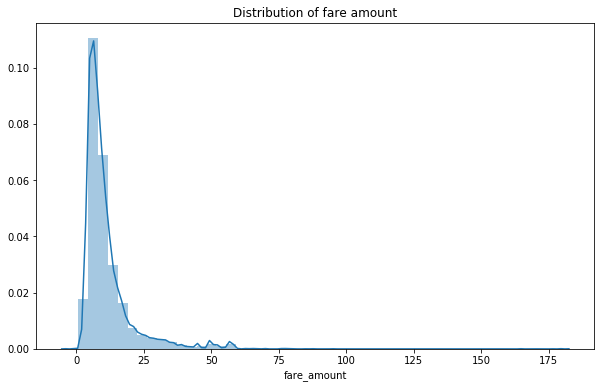

In [6]:
# the histogam and kernel density plot of fare amount
plt.figure(figsize = (10, 6))
sns.distplot(train_df['fare_amount'])
plt.title('Distribution of fare amount')

In [8]:
# check missing data
train_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

There is no missing data in the first 100k rows.

The fare amount values are put into bins with a increment of 5. It can be seen that a large portion of fare amount is in the range from 5 to 10. Overall, it exhibits a long-tailed distribution shape.

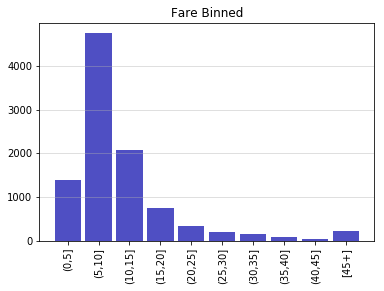

In [9]:
bins=[0,5,10,15,20,25,30,35,40,45,50]
data=np.array(train_df['fare_amount'])
n,bins,patches = plt.hist(np.clip(data,bins[0],bins[-1]),bins=bins,color='#0504aa',alpha=0.7,rwidth=0.85)
plt.grid(axis='y',alpha=0.5)
plt.xticks([2.5,7.5,12.5,17.5,22.5,27.5,32.5,37.5,42.5,47.5],('(0,5]','(5,10]','(10,15]','(15,20]','(20,25]','(25,30]','(30,35]','(35,40]','(40,45]','[45+]'),
           rotation=90)

plt.title('Fare Binned')
plt.show()

The distribution of passenger number is also checked. Most of them are in a reasonable range(1-6).

[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6')]

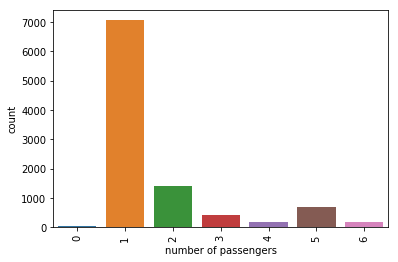

In [10]:
ax = sns.countplot(x="passenger_count",data=train_df,)
ax.set(xlabel='number of passengers')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## Map Trick

As the major information of the data is the pickup and dropoff locations, it's important to transfer the numerical location index to locations on map to reveal more useful information. This part is referred from other Kaggle kernel:https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration.

Because the dataset includes many pickup and dropoff locations and those locations can only along the roads in NYC. It's natural that the the locations show the map of NYC under large sample size. The outcome graphs are surprisely beautiful!

In [13]:
# function that select data within certian boundary box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# function that plot the scatter graph of the pickup and dropoff locations in NYC and Manhattan
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

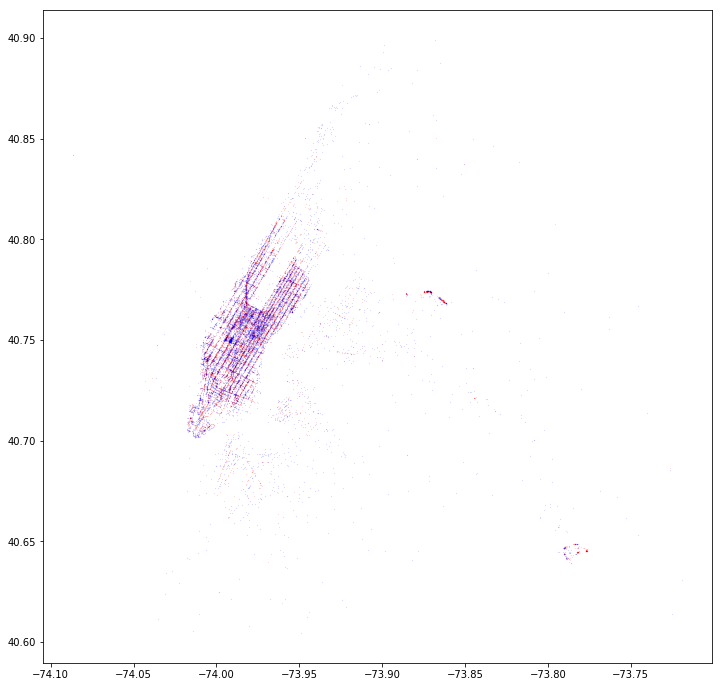

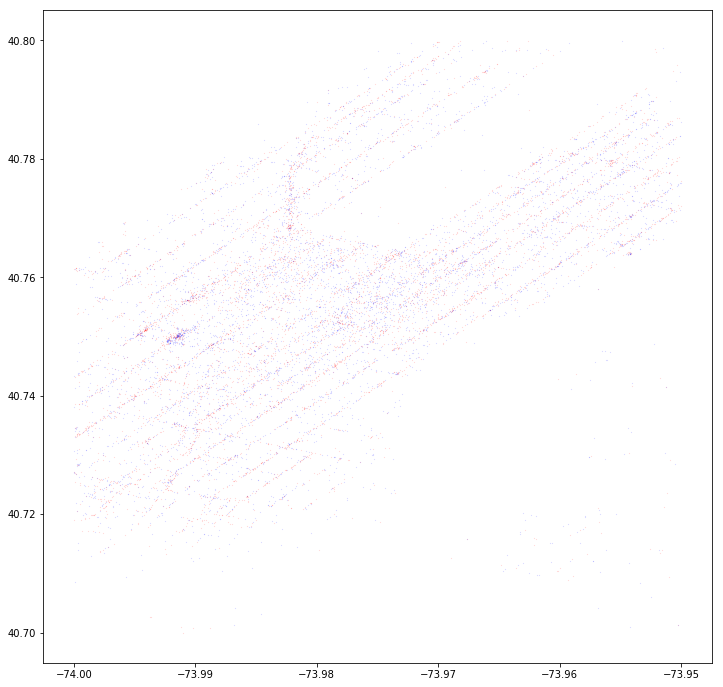

In [15]:
plot_hires(train_df, (-74.1, -73.7, 40.6, 40.9))
plot_hires(train_df, (-74, -73.95, 40.7, 40.8))

From thos scatter graphs, there exist some spots in the water area of NYC. To improve the performance of the model, those spots will be removed based on a land mask of NYC from https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png. 

## Distance and Feature Engineering

For the purpose of predicting the taxi fare, distance is a more direct parameter than the longitude and latitude. There are several different ways to define the distance between the pickup and dropoff locations. The direct distance of the distance on earth surface is the 'Euclidean distance' which can be calculate based on NYC location and the longtitude and latitude differences between the spots. Another defination of distance based on the fact that the roads on Manhattan are mostly parallel and have 29 degree to the longtitude. To have more realistic road distance we need to project the locations to a grid with 29 degree to the earth grid.

In [16]:
# function to calculate the distance between to locations.
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

# function to converte lon/lat distance to miles
def convert_miles(df):
    df['delta_lon_mile'] = abs(df.delta_lon)*50
    df['delta_lat_mile'] = abs(df.delta_lat)*69

In [18]:
train_df['distance_miles'] = distance(train_df.pickup_latitude, train_df.pickup_longitude, \
                                      train_df.dropoff_latitude, train_df.dropoff_longitude)

Because the taxi fare is dicrectly related to the distance, the relation between fare and distance is very important for the future model selection and feature engineering.

Text(0.5,1,'10K data')

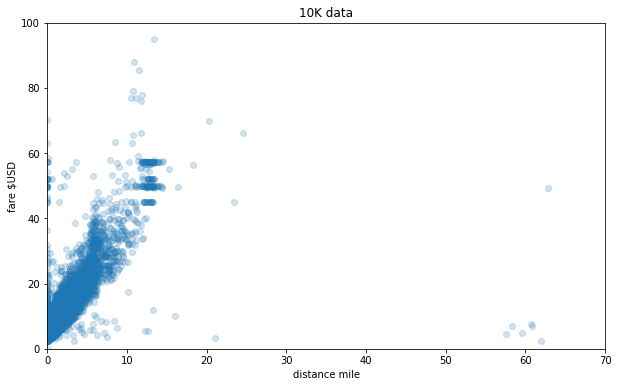

In [30]:
# scatter plot of distance - fare
plt.figure(figsize = (10, 6))
plt.scatter(train_df.distance_miles, train_df.fare_amount, alpha=0.2)
plt.xlabel('distance mile')
plt.ylabel('fare $USD')
plt.xlim([0,70])
plt.ylim([0,100])
plt.title('10K data')

This scatter graph indicates a near linear relation between fare and distance. However, it's clear there are some outliers that have long fare amount around 60 miles. Because one of the major aspect of taxi is airport pickup and dropoff, those outliers should be the airport taxi fair with fixed low expense and long distance.

Another import feature about the taxi information is the time of pickup and dropoff. Becasue the dataset only shows timestamp of the time. Year, Month, Day and hour information could be extracted from the timestamp. 

## Modularization of Feature Engineering

Based on the above explorations, the feature enginnering functions are defined for train and test datasets. (The map trick and airport locations are referred from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
% matplotlib inline
plt.style.use('seaborn-whitegrid')

# function that select data from certain longitude and latitude box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# function that remove the bad datapoints located in water area of NYC referred from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
#     print("Number of trips in water: {}".format(np.sum(~idx)))
    
    # return only datapoints on land
    return df[idx]

# function to calculate the distance based lon&lat of two spots
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# Another function that convert lon/lat to miles which is mostly the same function as above
def convert_miles(df):
    df['delta_lon_mile'] = abs(df.delta_lon)*50
    df['delta_lat_mile'] = abs(df.delta_lat)*69
    
# direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees. referred from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result# This Python 3 environment comes with many helpful analytics libraries installed

In [34]:
# function that feature engineering the train and test dataset
def process_data(test=False,rows=100000):
    
    if test==True:
        df_train =  pd.read_csv('../input/test.csv')
        df_train['pickup_datetime'] = df_train.pickup_datetime.apply(lambda t: pd.to_datetime(t))
        df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)
    else:
#         df_train = pd.read_csv('../input/train.csv', nrows = rows, parse_dates=["pickup_datetime"])
        df_train = pd.read_csv('train.csv', nrows = rows, parse_dates=["pickup_datetime"])
        df_train = df_train[df_train.fare_amount>=0]
        df_train = df_train.dropna(how = 'any', axis = 'rows')
    
        # lon/lat boundary box of NYC
        BB = (-74.5, -72.8, 40.5, 41.8)

        df_train = df_train[select_within_boundingbox(df_train, BB)]
        df_train = remove_datapoints_from_water(df_train)
        
        # convert lon/lat to miles on earth
        df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)
        idx = (df_train.distance_miles >= 0.05)
        df_train = df_train[idx]
        
        # extract the time information from the dataset
        df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
        df_train['month'] = df_train.pickup_datetime.apply(lambda t: t.month)
        df_train['day'] = df_train.pickup_datetime.apply(lambda t: t.day)
        df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
        df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

        # lon/lat of NYC and several airport near NYC referred from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
        nyc = (-74.0063889, 40.7141667)
        jfk = (-73.7822222222, 40.6441666667)
        ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
        lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA

        # New features that related to the airports
        df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train.pickup_latitude, df_train.pickup_longitude)
        df_train['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.pickup_latitude, df_train.pickup_longitude)
        df_train['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
        df_train['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.pickup_latitude, df_train.pickup_longitude)
        df_train['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
        df_train['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.pickup_latitude, df_train.pickup_longitude)
        df_train['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

        df_train['delta_lon'] = df_train.pickup_longitude - df_train.dropoff_longitude
        df_train['delta_lat'] = df_train.pickup_latitude - df_train.dropoff_latitude
        df_train['delta_lon_mile'] = abs(df_train.delta_lon)*50
        df_train['delta_lat_mile'] = abs(df_train.delta_lat)*69

        meas_ang = 0.506 # 29 degrees
        
        # road distance on manhattan based on the 29 degree tilte of the manhattan roads
        df_train['Euclidean'] = (df_train.delta_lat_mile**2 + df_train.delta_lon_mile**2)**0.5 ### as the crow flies  
        df_train['delta_manh_long'] = (df_train.Euclidean*np.sin(np.arctan(df_train.delta_lon_mile / df_train.delta_lat_mile)-meas_ang)).abs()
        df_train['delta_manh_lat'] = (df_train.Euclidean*np.cos(np.arctan(df_train.delta_lon_mile / df_train.delta_lat_mile)-meas_ang)).abs()
        df_train['manh_length'] = df_train.delta_manh_long + df_train.delta_manh_lat

        # Trip direction calculated from the lon/lat of pickup and dropoff
        df_train['direction'] = calculate_direction(df_train.delta_lon, df_train.delta_lat)

        return df_train.drop('distance_miles',axis=1)

In [35]:
train = process_data()

C:\Users\linsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in arctan
C:\Users\linsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in arctan


In [36]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,dropoff_distance_to_lgr,delta_lon,delta_lat,delta_lon_mile,delta_lat_mile,Euclidean,delta_manh_long,delta_manh_lat,manh_length,direction
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,...,4.256124,-0.002701,0.009041,0.13505,0.623829,0.638280,0.184232,0.611113,0.795345,106.633523
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,...,5.776991,-0.036780,-0.070701,1.83900,4.878369,5.213483,0.755904,5.158393,5.914297,-117.484306
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,...,6.485728,0.008504,0.010708,0.42520,0.738852,0.852465,0.013810,0.852354,0.866163,51.544361
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,...,6.414781,0.004437,-0.024949,0.22185,1.721481,1.735717,0.640321,1.613289,2.253611,-79.915791
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,...,4.632556,-0.011440,-0.015754,0.57200,1.087026,1.228336,0.026540,1.228049,1.254589,-125.985832


In [ ]:
# # Drop unnecessary or overlapped features to reduce overfitting
# train.drop(columns=['pickup_datetime','delta_lon_mile','delta_lat_mile','delta_lon','delta_lat','delta_manh_long','delta_manh_lat'], inplace=True)
# test = test.drop(columns=['pickup_datetime','delta_lon_mile','delta_lat_mile','delta_lon','delta_lat','delta_manh_long','delta_manh_lat'])

## Model and Prediction

In [38]:
import numpy as np 
import pandas as pd
import scipy as scipy
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import os
# import gc

# train_df = pd.read_csv('../input/train1.csv')
# test_df = pd.read_csv('../input/test1.csv')

In [ ]:
# construct the train and test datasets for the LGBT model
train_df.drop(columns=['key', 'pickup_datetime'], inplace=True)

y = train_df['fare_amount']
train_df = train_df.drop(columns=['fare_amount'])

x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=100,test_size=0.05)

del train_df
del y
# gc.collect()

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday','hour'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday','hour'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
del x_train
del y_train
del x_test
del y_test
gc.collect()

## Summary of the model performance

Based on the above data (10M data from train.csv) and model, I could reach 2.82 RMSE (Root Mean Square Error) after cross validation. However, the global RMSE on Kaggle is about 3.5 in the public leader board, which indicates we have overfitting in our model. I increased the train data to 12M, deleted some overlapped features and added more fold in corss validation to reduce overfitting. Finally, we had 3.02 global RMSE and stood top 18% over 1488 teams